# Chapter 1: Introduction to Hypothesis testing
A hypothesis is a statement about an unkown population parameter. A hypothesis test comapres two competing hypotheses. The null hypothesis is the existing idea and the alternative hypothesis is the new idea, challenging the existing idea. The initial assumption is that the null hypothesis is true. We need to have evidence beyond reasonable doubt to reject the existing idea (null hypothesis) in favour of new idea (alternative hypothesis). <br>
The tails of the distribution that are relevant depend on whether the alternative hypothesis refers to "greater than", "less than", or "differences between."

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random                 # np.random is a random package in numpy. Besides this one, there is a seperate package called random. Some
                              # functions are available in np.random whereas different functions are available in random.
import itertools
from scipy.stats import norm
from scipy.stats import t
import pingouin

pd.set_option("display.precision", 3)                #do not always work properly. But 
pd.options.display.float_format = '{:.3f}'.format   # suit for me, thanks a lot.

## 1.1. Hypothesis tests and z-scores

In [2]:
# Calculating the sample mean
# The late_shipments dataset contains supply chain data on the delivery of medical supplies. Each row represents one delivery of a part. The 
# late columns denotes whether or not the part was delivered late. A value of "Yes" means that the part was delivered late, and a value of "No"
# means the part was delivered on time.
# You'll begin your analysis by calculating a point estimate (or sample statistic), namely the proportion of late shipments.
# In pandas, a value's proportion in a categorical DataFrame column can be quickly calculated using the syntax: 
  # prop = (df['col'] == val).mean()

# Print the late_shipments dataset.
late_shipments= pd.read_feather('late_shipments.feather')
late_shipments.head()           # 1000 rows and 27 columns

,id,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,late_delivery,late,product_group,sub_classification,...,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,freight_cost_groups,line_item_insurance_usd
0,36203.000,Nigeria,PMO - US,Direct Drop,EXW,Air,1.000,Yes,HRDT,HIV test,...,2996.000,266644.000,89.000,0.890,"Alere Medical Co., Ltd.",Yes,1426.000,33279.830,expensive,373.830
1,30998.000,Botswana,PMO - US,Direct Drop,EXW,Air,0.000,No,HRDT,HIV test,...,25.000,800.000,32.000,1.600,"Trinity Biotech, Plc",Yes,10.000,559.890,reasonable,1.720
2,69871.000,Vietnam,PMO - US,Direct Drop,EXW,Air,0.000,No,ARV,Adult,...,22925.000,110040.000,4.800,0.080,Hetero Unit III Hyderabad IN,Yes,3723.000,19056.130,expensive,181.570
3,17648.000,South Africa,PMO - US,Direct Drop,DDP,Ocean,0.000,No,ARV,Adult,...,152535.000,361507.950,2.370,0.040,"Aurobindo Unit III, India",Yes,7698.000,11372.230,expensive,779.410
4,5647.000,Uganda,PMO - US,Direct Drop,EXW,Air,0.000,No,HRDT,HIV test - Ancillary,...,850.000,8.500,0.010,0.000,Inverness Japan,Yes,56.000,360.000,reasonable,0.010


In [3]:
# Calculate the proportion of late shipments in the sample; that is, the mean cases where the late column is "Yes".
late_prop_sample= (late_shipments['late']== 'Yes').mean()
late_prop_sample
# so, 6.1% of the shipments have arrived late based on the given sample. Or, the proportion of late shipments in the sample is 0.061 or 6.1%.

0.061

In [4]:
# Calculating a z-score
# Since variables have arbitrary ranges and units, we need to standardize them. For example, a hypothesis test that gave different answers if 
# the variables were in Euros instead of US dollars would be of little value. Standardization avoids that.
# One standardized value of interest in a hypothesis test is called a z-score. To calculate it, you need three numbers: the sample statistic 
# (point estimate), the hypothesized statistic, and the standard error of the statistic (estimated from the bootstrap distribution).
# The sample statistic is available as late_prop_samp.
# late_shipments_boot_distn is a bootstrap distribution of the proportion of late shipments, available as a list.
late_prop_sample   # 0.061 and is a point estimate of shipments that arrive late in sample

# construct the bootstrap distribution as:
late_shipments_boot_distribution= []
for i in range(1, 5001):
    late_shipments_boot_distribution.append((late_shipments.sample(frac= 1, replace= True)['late']=='Yes').mean())
    
late_shipments_boot_distribution[0:5]
len(late_shipments_boot_distribution)

5000

In [5]:
# Just for understanding of the above command
(late_shipments.sample(frac= 1, replace= True)['late']== 'Yes').mean()

0.061

In [6]:
# Hypothesize that the proportion of late shipments is 6%.
late_prop_hypo= 0.06
late_prop_sample # 0.061
# Calculate the standard error from the standard deviation of the bootstrap distribution.
std_error= np.std(late_shipments_boot_distribution, ddof= 1)
std_error     # 0.0075 is the standard deviation of the distribution of 5000 proportions (means) of late shipments.
# Calculate the z_score
z_score= (late_prop_sample - late_prop_hypo)/std_error
z_score        # our sample statistic (0.061) is 0.133 standard deviations (of the bootstrap distribution) above the hypthesized population
               # mean (0.06).
# The z-score is a standardized measure of the difference between the sample statistic and the hypothesized statistic.

0.13224550488465356

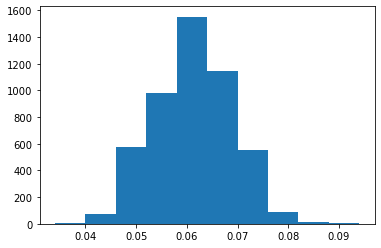

In [7]:
plt.hist(late_shipments_boot_distribution)
plt.show()

## 1.2. P-values
P-value measures the probability of obtaining a result, assuming the null hypothesis is true. Small p-values reject the null hypothesis. <br>
To calculate a p-value, we first must calculate a z-score as calculated above. <br>
The tails of the distribution that are relevant depend on whether the alternative hypothesis refers to "greater than", "less than", or "differences between." <br>
The p-value is calculated by transforming the z-score with the standard normal cumulative distribution function.

In [8]:
# Calculating p-values
# In order to determine whether to choose the null hypothesis or the alternative hypothesis, you need to calculate a p-value from the z-score.
# You'll now return to the late shipments dataset and the proportion of late shipments.
# The null hypothesis is that the proportion of late shipments is six percent. The alternative hypothesis is that the proportion of late 
# shipments is greater than six percent.
# The observed sample statistic, late_prop_samp, the hypothesized value, late_prop_hyp (6%), and the bootstrap standard error, std_error are 
# available. norm from scipy.stats has also been loaded without an alias.
late_prop_sample   # 0.061
late_prop_hypo     # 0.06
std_error          # 0.0075

# Calculate the z-score of late_prop_samp.
z_score= (late_prop_sample - late_prop_hypo) / std_error
z_score            # 0.1333

# Calculate the p-value for the z-score, using a right-tailed test.
p_value= norm.cdf(z_score, loc= 0, scale= 1)   # 0.553 = norm.cdf(z_score, loc= 0, scale= 1). To get a value equal to or less than 0.1333
p_value                                        # in a normal distribution with mean 0 and standard devition 1 has a probability of 0.553 or
                                               # 55.3 percent.
p_value= 1 - p_value
p_value                                       # to get a value equal to or greater than 0.1333 has a probability of 0.447 or 44.7%. We fail 
                                              # to reject (accept) the null hypothesis and conclude that the proportion of late shipments is 
                                              # six percent. Thus, the difference of 0.1% (6.1% - 6%) is merely by a chance.

0.4473950547370963

## 1.3. Statistical significance
Significance level gives us a cut-off point to decide which hypothesis to support.
If a p-value is less than or equal to a significance level (alpha), we reject the null hypothesis. <br>
False positive is when a null hypothesis is correct in a whole population and still it is rejected, on the basis of sample evidence, in favour of alternative hypothesis (Type I error). False negative is when a null hypothesis is not rejected (accepted) when alternative hypothesis is correct in a whole population (Type II error). 

In [9]:
# Calculating a confidence interval
# If you give a single estimate of a sample statistic, you are bound to be wrong by some amount. For example, the hypothesized proportion of 
# late shipments was 6%. Even if evidence suggests the null hypothesis that the proportion of late shipments is equal to this, for any new 
# sample of shipments, the proportion is likely to be a little different due to sampling variability. Consequently, it's a good idea to state
# a confidence interval. That is, you say, "we are 95% 'confident' that the proportion of late shipments is between A and B" (for some value of
# A and B).
# Sampling in Python demonstrated two methods for calculating confidence intervals. Here, you'll use quantiles of the bootstrap distribution 
# to calculate the confidence interval.
# late_prop_samp and late_shipments_boot_distn are available; pandas and numpy are loaded with their usual aliases.
late_prop_sample
len(late_shipments_boot_distribution)

# Calculate a 95% confidence interval from late_shipments_boot_distn using the quantile method, labeling the lower and upper intervals lower 
# and upper.
lower= np.quantile(late_shipments_boot_distribution, 0.025)
upper= np.quantile(late_shipments_boot_distribution, 0.975)
lower                                 # 0.047 or 4.7%  # though we did not reject the null hypothesis and concluded that there the percentage
upper                                 # 0.075 or 7.5%. # of late shipments is not greater than 6%, yet there is a chance that the future late
                                                       # shipments percentages are different than 6%. The confidence interval tells us that
                                                       # we are 95% confident that the percentage of late shipments in the whole population
                                                       # is between 4.7% and 7.5%.

# When you have a confidence interval width equal to one minus the significance level, if the hypothesized population parameter is within the 
# confidence interval, you should fail to reject the null hypothesis.

0.076

# Chapter 2: Two-sample and ANOVA tests

## 2.1. Performing t-tests
Comapres sample statistics across groups in a variable. <br>
The hypothesis test for determining if there is a difference between the means of two populations uses a different type of test statistic to
the z-scores you saw in Chapter 1. It's called "t", and it can be calculated from three values from each sample using this equation.
insert equation from the slides of this chapter. <br>
Using a sample standard deviation to estimate the standard error is computationally easier than using bootstrapping. However, to correct for the approximation, you need to use a t-distribution when transforming the test statistic to get the p-value. <br>
The normal distribution is essentially a t-distribution with infinite degrees of freedom.

In [10]:
# Two sample mean test statistic
# The hypothesis test for determining if there is a difference between the means of two populations uses a different type of test statistic to
# the z-scores you saw in Chapter 1. It's called "t", and it can be calculated from three values from each sample using this equation.
# insert equation from the slides of this chapter.
# While trying to determine why some shipments are late, you may wonder if the weight of the shipments that were on time is less than the 
# weight of the shipments that were late. The late_shipments dataset has been split into a "yes" group, where late == "Yes" and a "no" group 
# where late == "No". The weight of the shipment is given in the weight_kilograms variable.
# The sample means for the two groups are available as xbar_no and xbar_yes. The sample standard deviations are s_no and s_yes. The sample 
# sizes are n_no and n_yes. numpy is also loaded as np.

# group the dataframe by the column 'late' which has values 'Yes' and 'No'
late_groups= late_shipments.groupby('late')
late_groups
# find the mean weight for each group and assign them to their respective group names
xbar= late_groups['weight_kilograms'].mean()
xbar_no= xbar['No']
xbar_yes= xbar['Yes']

# find the standard deviation of each group and assign them to their respective group names
s_dev= late_groups['weight_kilograms'].std()   # since this late_shipments is a sample, therefore, we don't have to specify ddof= 1 when using
s_dev                                          # std() on a series or on a series object at the end of the command.
s_no= s_dev['No']
s_yes= s_dev['Yes']

# find the each group size and assign them to their respective group names
size= late_groups['weight_kilograms'].count()
n_no= size['No']
n_yes= size['Yes']

print(xbar_no, xbar_yes, s_no, s_yes, n_no, n_yes)

1897.7912673056444 2715.6721311475408 3154.0395070841687 2544.688210903328 939 61


In [11]:
# Calculate the numerator of the test statistic
numerator= (xbar_yes - xbar_no)
numerator        # 817.88. the mean weight in yes group is 817.88 kgs greater than the mean weight in no group.
# Calculate the denominator of the test statistic
denominator= np.sqrt((s_yes ** 2 / n_yes) + (s_no ** 2 / n_no))
denominator     # 341.6854. This is the standard error.
# # Calculate the t test statistic
t_stat= numerator / denominator
t_stat          # the t_stat is 2.39. The interpretation has to be done in later exercises.

# When testing for differences between means, the test statistic is called 't' rather than 'z', and can be calculated using six 
# numbers from the samples. Here, the value is about -2.39 or 2.39, depending on the order you calculated the numerator.

2.3936661778766433

## 2.2. Calculating p-values from t-statistics
Degrees of freedom is the maximum number of logically independent values in the data sample. Suppose, a sample has 5 independent values as: 2, 4, 5, 3 and a fifth value. Let's say this sample has a mean of 4. That means, the fifth value is not independent, that is, it must be 6 for the mean of the sample to be equal to 4. Thus, we can freely/independently choose 4 out of 5 values to have a mean of 4, but the fifth value has to be restricted. Thus, the degrees of freedom here is 4. <br>
z-statistic is needed when using one sample statistic to estimate a population parameter. <br>
t-statistic is needed when using multiple sample statistics (such as sample mean and sample standard deviation) to estimate a population parameter. 

In [14]:
# From t to p
# Previously, you calculated the test statistic for the two-sample problem of whether the mean weight of shipments is smaller for shipments 
# that weren't late (late == "No") compared to shipments that were late (late == "Yes"). In order to make decisions about it, you need to 
# transform the test statistic with a cumulative distribution function to get a p-value.
# Recall the hypotheses:
# Ho: The mean weight of shipments that weren't late is the same as the mean weight of shipments that were late.
# Ha: The mean weight of shipments that weren't late is less than the mean weight of shipments that were late.
# The test statistic, t_stat, is available, as are the samples sizes for each group, n_no and n_yes. Use a significance level of alpha = 0.05.
# t has also been imported from scipy.stats.
alpha= 0.05
print(xbar_no, xbar_yes, s_no, s_yes, n_no, n_yes)  # 1897.7912673056444 2715.6721311475408 3154.0395070841687 2544.688210903328 939 61

# Calculate the degrees of freedom for the test.
degrees_of_freedom= n_no + n_yes - 2
degrees_of_freedom      # 998 since both subgroups have total size = 1000

# Compute the p-value using the test statistic, t_stat
t_stat= -t_stat                 # 2.39 computed above. But changed here to -2.39 since the alternative hypothesis evaluates one sample weight
t_stat                          # being less than another sample weight (the no vs yes samples). Or subtract the 'yes' sample mean weight from
                                # 'no' sample mean wegith so that the numerator in the above cell becomses negative so that we can have the 
                                # left tail to work with. If the Ha evaluates that the 'yes' sample mean weight is greater than the 'no' sample
                                # mean weight, then we should work with the right tail, which requires to have positive t-statistics which fur-
                                # ther requires that 'no' sample mean weight should be subtracted from the 'yes' sample mean weight.

1897.7912673056444 2715.6721311475408 3154.0395070841687 2544.688210903328 939 61


-2.3936661778766433

In [15]:
p_value= t.cdf(t_stat, df= degrees_of_freedom)      # 0.0084. loc= 0, scale= 1 are optional since they are the default values and gets 
p_value                                             # the same result. t-distribution with mean 0 and standard deviation 1 with 998 dof
                                                    # have 0.84% values below -2.39. Alternatively, stating that the probability of getting
                                                    # the 'no' sample mean weight (1897.79) this much lower than the 'yes' sample mean weight 
                                                    # (2715.67) is only 0.84% out of 100%. Thus, the null of no weight difference is rejected
                                                    # to conclude that the shipments that arrive on time are indeed lighter in weight than the
                                                    # shipments that arrive late.
                    
# When the standard error is estimated from the sample standard deviation and sample size, the test statistic is transformed into a p-value 
# using the t-distribution. (standard error is estimated from the sample standard deviation and sample size a few cells above rather than esti-
# mating it from the bootstrap distribution).

0.008432382146249523

## 2.3. Paired t-test
If you have repeated observations of something, then those observations form pairs. For example, conducting an election survey in a same city in different years.

In [16]:
# Visualizing the difference
# Before you start running hypothesis tests, it's a great idea to perform some exploratory data analysis; that is, calculating summary 
# statistics and visualizing distributions.
# Here, you'll look at the proportion of county-level votes for the Democratic candidate in 2012 and 2016, sample_dem_data. Since the counties
# are the same in both years, these samples are paired. The columns containing the samples are dem_percent_12 and dem_percent_16.
# dem_votes_potus_12_16 is available as sample_dem_data. pandas and matplotlib.pyplot are loaded with their usual aliases.

# import the data
sample_dem_data= pd.read_feather('dem_votes_potus_12_16.feather')
sample_dem_data

# Create a new diff column containing the percentage of votes for the democratic candidate in 2012 minus the percentage of votes for the 
# democratic candidate in 2016.
sample_dem_data['diff']= sample_dem_data['dem_percent_12'] - sample_dem_data['dem_percent_16']
sample_dem_data         # 500 rows and 5 columns.

,state,county,dem_percent_12,dem_percent_16,diff
0,Alabama,Bullock,76.306,74.947,1.359
1,Alabama,Chilton,19.454,15.847,3.606
2,Alabama,Clay,26.674,18.675,7.999
3,Alabama,Cullman,14.662,10.028,4.634
4,Alabama,Escambia,36.916,31.021,5.895
...,...,...,...,...,...
495,Wyoming,Uinta,19.065,14.191,4.874
496,Wyoming,Washakie,20.132,13.949,6.183
497,Alaska,District 3,33.515,16.301,17.214
498,Alaska,District 18,61.284,52.810,8.474


In [17]:
# Calculate the mean of the diff column as xbar_diff.
xbar_diff= sample_dem_data['diff'].mean()   # we could have alternatively taken the each column mean to make it a two sample mean test.
xbar_diff        # the mean difference is 6.829%. On average the democrat votes have reduced by 6.829% from 2012 to 2016 based on our sample.

6.829312660106832

In [18]:
# Calculate the standard deviation of the diff column as s_diff
s_diff= sample_dem_data['diff'].std()
s_diff        # the standard deviaiton of the difference column/series is 5.04% showing average dispersion around the mean calculated above.

5.040139140132316

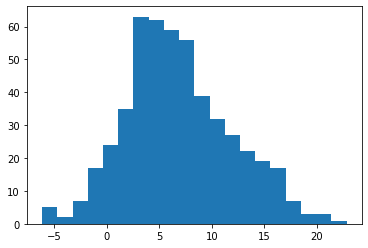

In [19]:
# Plot a histogram of the diff column with 20 bins.
fig, ax= plt.subplots()
ax.hist(sample_dem_data['diff'], bins= 20)    # looks kind of normal distribution
plt.show()

In [20]:
print(xbar_diff, s_diff)

6.829312660106832 5.040139140132316


In [35]:
# As in the previous exercise, you'll explore the difference between the proportion of county-level votes for the Democratic candidate in 2012 
# and 2016 to identify if the difference is significant.
   # Ho: There is no difference in the proportion of county-level votes for the Democratic candidate in 2012 and 2016.
   # Ha: There is difference in the proportion of county-level votes for the Democratic candidate in 2012 and 2016.

len(sample_dem_data)       # or
n_diff= len(sample_dem_data['diff'])
print(n_diff)

degrees_of_freedom= n_diff - 1
print(degrees_of_freedom)

t_stat= (xbar_diff - 0) / np.sqrt(s_diff ** 2 / n_diff)
print(t_stat)

p_value = 1 - t.cdf(t_stat, degrees_of_freedom)
print(p_value)
p_value = p_value * 2  # for two-sided t test
print(p_value)

500
499
30.298384475151405
0.0
0.0


In [36]:
# Using ttest()
# Manually calculating test statistics and transforming them with a CDF to get a p-value is a lot of effort to compare two sample means. The 
# comparison of two sample means is called a t-test, and the pingouin Python package has a .ttest() method to accomplish it. This method 
# provides some flexibility in how you perform the test.
# As in the previous exercise, you'll explore the difference between the proportion of county-level votes for the Democratic candidate in 2012
# and 2016 to identify if the difference is significant.
# sample_dem_data is available and has the columns diff, dem_percent_12, and dem_percent_16 in addition to the state and county names. 
# pingouin and has been loaded along with pandas as pd.
sample_dem_data

# Conduct a t-test on the sample differences (the diff column of sample_dem_data), using an appropriate alternative hypothesis chosen from 
# "two-sided", "less", and "greater".
test_results= pingouin.ttest(x= sample_dem_data['diff'], y= 0, alternative= 'two-sided')  # y= 0 is the hypothesized mean difference in Ho.
test_results

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,30.298,499,two-sided,0.000,"[6.39, 7.27]",1.355,2.246e+111,1.000


In [42]:
# Conduct a paired test on the democratic votes in 2012 and 2016 (the dem_percent_12 and dem_percent_16 columns of sample_dem_data), using an 
# appropriate alternative hypothesis.
paired_test_results= pingouin.ttest(x= sample_dem_data['dem_percent_12'], y= sample_dem_data['dem_percent_16'], paired= True, \
                                    alternative= 'two-sided')
paired_test_results               # same result as above. Thus, for a paired t-test, we can compute the difference column and conduct the paired
                                  # t-test without specify 'paired=True' or without computing the difference, we can specify both the columns
                                  # or samples as x and y and then also specify 'paired=True' to conduct the same paired t-test and obtain the
                                  # same result.

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,30.298,499,two-sided,0.000,"[6.39, 7.27]",0.454,2.246e+111,1.000


In [44]:
# Compare the paired t-test to an (inappropriate) unpaired test on the same data. How does the p-value change?
pingouin.ttest(x= sample_dem_data['dem_percent_12'], y= sample_dem_data['dem_percent_16'], alternative= 'two-sided')

# The p-value from the unpaired test is greater than than the p-value from the paired test (if taken to the highest precision as on DataCamp).

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,7.182,998,two-sided,0.000,"[4.96, 8.7]",0.454,4.308e+09,1.000


## 2.4. ANOVA tests
ANOVA can be used to analyze the differences between more than two groups. For two groups, unpaired or paired t test can be used.

shipment_mode
Air           39.712
Air Charter    4.227
Ocean          6.432
Name: pack_price, dtype: float64 shipment_mode
Air           48.933
Air Charter    0.993
Ocean          5.303
Name: pack_price, dtype: float64


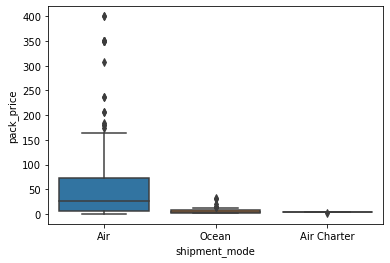

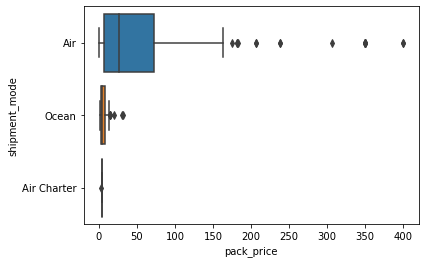

In [57]:
# Visualizing many categories
# So far in this chapter, we've only considered the case of differences in a numeric variable between two categories. Of course, many datasets 
# contain more categories. Before you get to conducting tests on many categories, it's often helpful to perform exploratory data analysis (EDA),
# calculating summary statistics for each group and visualizing the distributions of the numeric variable for each category using box plots.
# Here, we'll return to the late shipments data, and how the price of each package (pack_price) varies between the three shipment modes 
# (shipment_mode): "Air", "Air Charter", and "Ocean".
# late_shipments is available; pandas and matplotlib.pyplot are loaded with their standard aliases, and seaborn is loaded as sns.
late_shipments= pd.read_feather('late_shipments.feather')

# Group late_shipments by shipment_mode and calculate the mean pack_price for each group, storing the result in xbar_pack_by_mode.
xbar_pack_by_mode= late_shipments.groupby('shipment_mode')['pack_price'].mean()
xbar_pack_by_mode

# Group late_shipments by shipment_mode and calculate the standard deviation pack_price for each group, storing the result in s_pack_by_mode.
s_pack_by_mode= late_shipments.groupby('shipment_mode')['pack_price'].std()

print(xbar_pack_by_mode, s_pack_by_mode)

# Create a boxplot from late_shipments with "pack_price" as x and "shipment_mode" as y.
sns.boxplot(x= 'shipment_mode', y= 'pack_price', data= late_shipments)  # this x and y makes more sense since pack_price should depend on 
plt.show()                                                              # shipment_mode.

sns.boxplot(x= 'pack_price', y= 'shipment_mode', data= late_shipments)  # this is what DataCamp requires.
plt.show()

# There certainly looks to be a difference in the pack price between each of the three shipment modes. Do you think the differences are 
# statistically significant? Let's do hypothesis testing.

In [61]:
# Conducting an ANOVA test
# The box plots made it look like the distribution of pack price was different for each of the three shipment modes. However, it didn't tell us 
# whether the mean pack price was different in each category. To determine that, we can use an ANOVA test. The null and alternative hypotheses 
# can be written as follows.
  # Ho: Pack prices for every category of shipment mode are the same.
  # Ha: Pack prices for some categories of shipment mode are different.
# We'll set a significance level of 0.1.
alpha= 0.1
# late_shipments is available and pingouin has been loaded.

# Run an ANOVA on late_shipments investigating 'pack_price' (the dependent variable) between the groups of 'shipment_mode'.
anova_results= pingouin.anova(data= late_shipments, dv= 'pack_price', between= 'shipment_mode') 
anova_results
# the pack_price is significantly different between two groups at least out of total 3 groups (air, air_chart, ocean).

# There is a significant difference in pack prices between the shipment modes. However, we don't know which shipment modes this applies to.

,Source,ddof1,ddof2,F,p-unc,np2
0,shipment_mode,2,997,21.865,0.000,0.042


In [64]:
# Pairwise t-tests
# The ANOVA test didn't tell you which categories of shipment mode had significant differences in pack prices. To pinpoint which categories had 
# differences, you could instead use pairwise t-tests.
# late_shipments is available and pingouin has been loaded.

# Perform pairwise t-tests on late_shipments's pack_price variable, grouped by shipment_mode, without doing any p-value adjustment.
pairwise_results= pingouin.pairwise_ttests(data= late_shipments, dv= 'pack_price', between= 'shipment_mode', padjust= 'none')
pairwise_results

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,shipment_mode,Air,Air Charter,False,True,21.180,600.686,two-sided,0.000,5.809e+76,0.727
1,shipment_mode,Air,Ocean,False,True,19.336,986.980,two-sided,0.000,1.129e+67,0.711
2,shipment_mode,Air Charter,Ocean,False,True,-3.171,35.615,two-sided,0.003,15.277,-0.424


In [66]:
pairwise_results_bonf= pingouin.pairwise_ttests(data= late_shipments, dv= 'pack_price', between= 'shipment_mode', padjust= 'bonf')
pairwise_results_bonf

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,shipment_mode,Air,Air Charter,False,True,21.180,600.686,two-sided,0.000,0.000,bonf,5.809e+76,0.727
1,shipment_mode,Air,Ocean,False,True,19.336,986.980,two-sided,0.000,0.000,bonf,1.129e+67,0.711
2,shipment_mode,Air Charter,Ocean,False,True,-3.171,35.615,two-sided,0.003,0.009,bonf,15.277,-0.424


# Chapter 3: Proportion Tests
The t-test is needed for tests of mean(s) since you are estimating two unknown quantities, which leads to more variability.

In [ ]:
# This is just for testing.